In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.stats.multitest import multipletests


In [2]:
START_DATE = "2009-10-27" # First day filtering
END_DATE = "2019-10-22" # Last day filtering

# Teams in NBA based on dataset
WESTERN_CONFERENCE_TEAMS = ['Portland Trail Blazers', 'Los Angeles Lakers', 'Dallas Mavericks', 'Golden State Warriors', 'Denver Nuggets',
                            'Los Angeles Clippers', 'San Antonio Spurs', 'Minnesota Timberwolves', 'Memphis Grizzlies', 'New Orleans Hornets',
                            'Phoenix Suns', 'Oklahoma City Thunder', 'Utah Jazz', 'Houston Rockets', 'Sacramento Kings', 'LA Clippers', 'New Orleans Pelicans']

EASTERN_CONFERENCE_TEAMS = ['Cleveland Cavaliers', 'Atlanta Hawks', 'Miami Heat', 'Boston Celtics',  'Orlando Magic', 'Toronto Raptors',
                            'Chicago Bulls', 'New Jersey Nets', 'Detroit Pistons', 'Charlotte Bobcats', 'Philadelphia 76ers', 'Indiana Pacers', 
                            'Washington Wizards', 'New York Knicks', 'Milwaukee Bucks', 'Brooklyn Nets', 'Charlotte Hornets']
ALL_NBA_TEAMS = WESTERN_CONFERENCE_TEAMS + EASTERN_CONFERENCE_TEAMS
METRICS = ['pts_home', 'fg_pct_home', 'fg3_pct_home', 'ft_pct_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home']

In [3]:
#   Create DataFrame for summary and filter data
summary_df = pd.read_csv("game.csv")
summary_df['game_date'] = pd.to_datetime(summary_df['game_date'])
range_dataframe = summary_df[(summary_df['game_date'] >= START_DATE) & (summary_df['game_date'] < END_DATE)]
range_dataframe = range_dataframe[range_dataframe['team_name_home'].isin(ALL_NBA_TEAMS)]

C:\Users\oshom\AppData\Local\Temp\ipykernel_31600\540828079.py:53: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



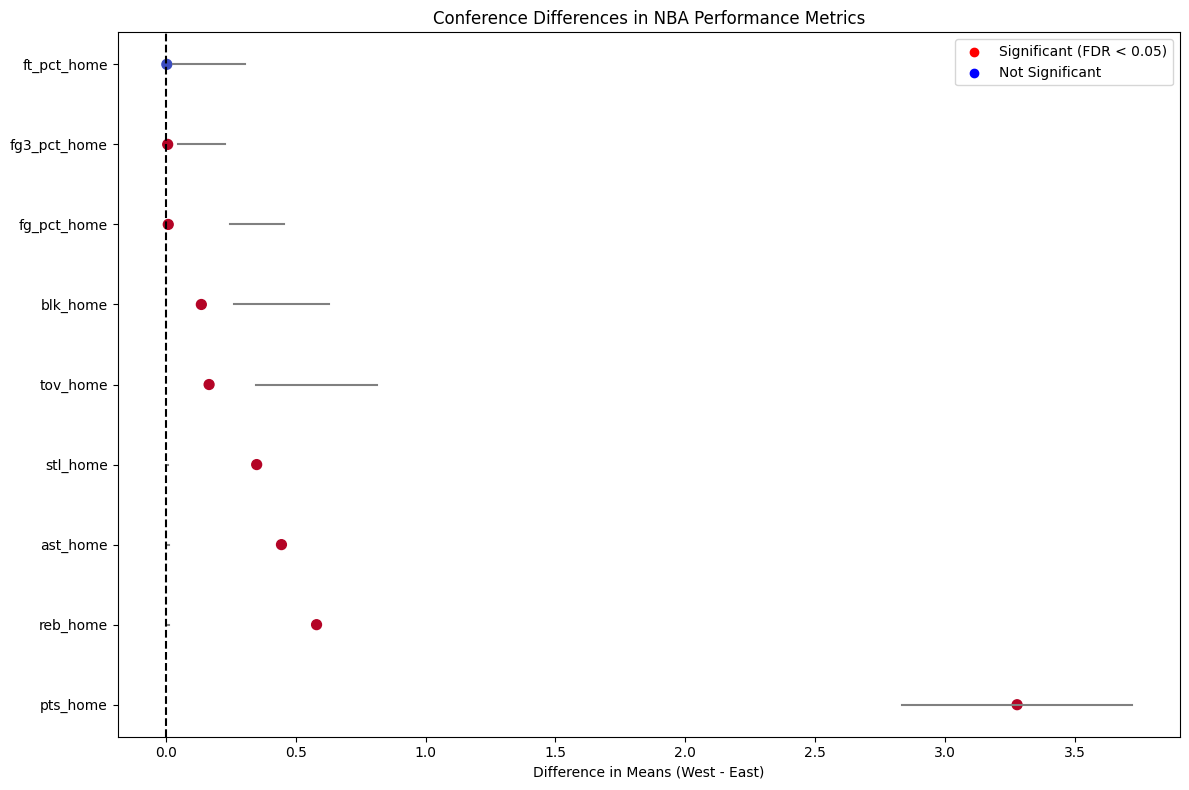

In [5]:
def create_forest_plot(range_dataframe, WESTERN_CONFERENCE_TEAMS, EASTERN_CONFERENCE_TEAMS, METRICS):
    results = []
    for metric in METRICS:
        western = range_dataframe[range_dataframe['team_name_home'].isin(WESTERN_CONFERENCE_TEAMS)][metric]
        eastern = range_dataframe[range_dataframe['team_name_home'].isin(EASTERN_CONFERENCE_TEAMS)][metric]
        
        mean_diff = np.mean(western) - np.mean(eastern)
        std_error = np.sqrt(np.var(western)/len(western) + np.var(eastern)/len(eastern))
        ci_lower, ci_upper = stats.t.interval(0.95, len(western) + len(eastern) - 2, loc=mean_diff, scale=std_error)
        t_stat, p_value = stats.ttest_ind(western, eastern)
        
        results.append({
            'metric': metric,
            'mean_diff': mean_diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'p_value': p_value
        })
    
    results_df = pd.DataFrame(results)
    
    # Perform FDR correction
    results_df['fdr_bh'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    
    # Sort by absolute mean difference
    results_df = results_df.sort_values('mean_diff', key=abs, ascending=False)
    
    # Create the forest plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_positions = range(len(results_df))
    ax.scatter(results_df['mean_diff'], y_positions, c=results_df['fdr_bh'] < 0.05, cmap='coolwarm', s=50)
    
    for i, row in results_df.iterrows():
        ax.plot([row['ci_lower'], row['ci_upper']], [i, i], color='gray')
    
    ax.axvline(x=0, color='black', linestyle='--')
    ax.set_yticks(y_positions)
    ax.set_yticklabels(results_df['metric'])
    ax.set_xlabel('Difference in Means (West - East)')
    ax.set_title('Conference Differences in NBA Performance Metrics')
    
    # Add a legend
    ax.scatter([], [], c='red', label='Significant (FDR < 0.05)')
    ax.scatter([], [], c='blue', label='Not Significant')
    ax.legend()
    
    plt.tight_layout()
    return fig

# Create and show the plot
forest_plot = create_forest_plot(range_dataframe, WESTERN_CONFERENCE_TEAMS, EASTERN_CONFERENCE_TEAMS, METRICS)
forest_plot.show()

C:\Users\oshom\AppData\Local\Temp\ipykernel_31600\3392974643.py:52: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



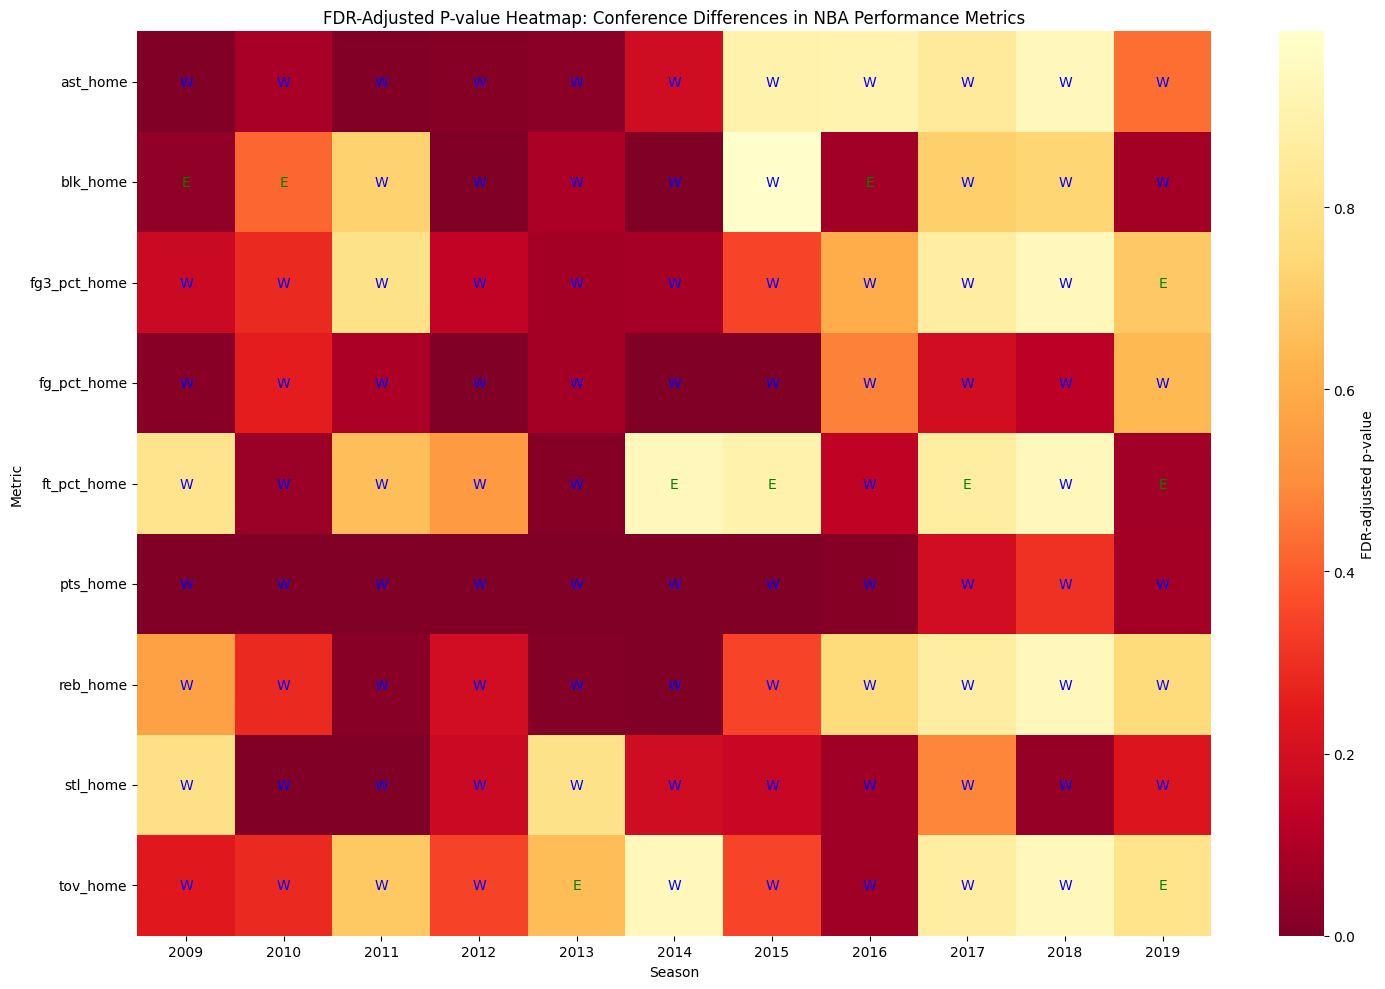

In [6]:
def create_pvalue_heatmap(range_dataframe, WESTERN_CONFERENCE_TEAMS, EASTERN_CONFERENCE_TEAMS, METRICS):
    # Add a season column
    range_dataframe['season'] = range_dataframe['game_date'].dt.to_period('Y')
    
    results = []
    for season in range_dataframe['season'].unique():
        season_data = range_dataframe[range_dataframe['season'] == season]
        for metric in METRICS:
            western = season_data[season_data['team_name_home'].isin(WESTERN_CONFERENCE_TEAMS)][metric]
            eastern = season_data[season_data['team_name_home'].isin(EASTERN_CONFERENCE_TEAMS)][metric]
            
            t_stat, p_value = stats.ttest_ind(western, eastern)
            mean_diff = np.mean(western) - np.mean(eastern)
            
            results.append({
                'season': season,
                'metric': metric,
                'p_value': p_value,
                'mean_diff': mean_diff
            })
    
    results_df = pd.DataFrame(results)
    
    # Perform FDR correction for each season
    results_df['fdr_bh'] = results_df.groupby('season')['p_value'].transform(lambda x: multipletests(x, method='fdr_bh')[1])
    
    # Prepare data for heatmap
    heatmap_data = results_df.pivot(index='metric', columns='season', values='fdr_bh')
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap='YlOrRd_r', ax=ax, cbar_kws={'label': 'FDR-adjusted p-value'})
    
    ax.set_title('FDR-Adjusted P-value Heatmap: Conference Differences in NBA Performance Metrics')
    ax.set_xlabel('Season')
    ax.set_ylabel('Metric')
    
    # Add markers for which conference has the higher value
    for i, metric in enumerate(heatmap_data.index):
        for j, season in enumerate(heatmap_data.columns):
            mean_diff = results_df[(results_df['metric'] == metric) & (results_df['season'] == season)]['mean_diff'].values[0]
            if mean_diff > 0:
                ax.text(j+0.5, i+0.5, 'W', ha='center', va='center', color='blue')
            else:
                ax.text(j+0.5, i+0.5, 'E', ha='center', va='center', color='green')
    
    plt.tight_layout()
    return fig

# Create and show the plot
heatmap_plot = create_pvalue_heatmap(range_dataframe, WESTERN_CONFERENCE_TEAMS, EASTERN_CONFERENCE_TEAMS, METRICS)
heatmap_plot.show()